# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we study the effect of the negative pairs rate. In dual-encoder training, we generate negative pairs from the original data set consisting only of positive pairs. The number of negative pairs for one positive pair, which we call negative pairs rate, is one hyperparameter in our model.

## 1. Preparation
As always, prepare the dataset for the training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [ ]:
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 99/99 [00:20<00:00,  4.90it/s]

Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:44<00:00, 22.22it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:06<00:00,  7.15it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:19<00:00, 21.59it/s]


=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


## 2. Random Search
Try different negative pairs rate and observe the performance. Because of the different negative pairs rate, each setting processes different numbers of data in each epoch. To adjust this so that all models will be trained on roughly the same number of image-text pairs, we modify the number of epochs.

In [ ]:
base_epochs = 20
batch_size = 128
embed_dim = 256
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

neg_rate_pool = [1, 2, 4, 8, 16]
train_losses, eval_losses, eval_loss_decomposed, image_MedR = [], [], [], []

for neg_rate in neg_rate_pool:
    print(f"\nNegative Pairs Rate = {neg_rate:.0f}")
    image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
    text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
    criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
    image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
    text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

    trainloader.dataset.set_neg_rate(neg_rate)

    train_loss, eval_loss = [], []
    epochs = math.ceil(base_epochs * (1 + 4) / (1 + neg_rate))
    for epoch in range(epochs):
        trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
        train_loss.append(trainloss)
        evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
        eval_loss.append(evalloss)
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
    pos_loss, neg_loss = utils.eval_decomposed(testloader, image_head, text_head)
    _, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)
    MedR = utils.getMedR(testloader, sim_mat)
    
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    eval_loss_decomposed.append([pos_loss, neg_loss])
    image_MedR.append(MedR["image"])
    neg_rate_loss = {"train": train_losses, "test": eval_losses, "neg_rate": neg_rate_pool, "MedR": image_MedR}
    with open(f"drive/My Drive/finalproj/neg_rate_loss.pkl", "wb") as f:
        pickle.dump(neg_rate_loss, f)


Negative Pairs Rate = 1
   Epoch: 5 | Training loss: 0.1288 | Test loss: 0.1865
   Epoch: 10 | Training loss: 0.1036 | Test loss: 0.1698
   Epoch: 15 | Training loss: 0.0927 | Test loss: 0.1624
   Epoch: 20 | Training loss: 0.0846 | Test loss: 0.1566
   Epoch: 25 | Training loss: 0.0781 | Test loss: 0.1517
   Epoch: 30 | Training loss: 0.0732 | Test loss: 0.1501
   Epoch: 35 | Training loss: 0.0692 | Test loss: 0.1497
   Epoch: 40 | Training loss: 0.0664 | Test loss: 0.1464
   Epoch: 45 | Training loss: 0.0639 | Test loss: 0.1445
   Epoch: 50 | Training loss: 0.0615 | Test loss: 0.1416

Negative Pairs Rate = 2
   Epoch: 5 | Training loss: 0.1046 | Test loss: 0.1460
   Epoch: 10 | Training loss: 0.0826 | Test loss: 0.1336
   Epoch: 15 | Training loss: 0.0741 | Test loss: 0.1292
   Epoch: 20 | Training loss: 0.0684 | Test loss: 0.1265
   Epoch: 25 | Training loss: 0.0642 | Test loss: 0.1257
   Epoch: 30 | Training loss: 0.0620 | Test loss: 0.1246

Negative Pairs Rate = 4
   Epoch: 5 | T

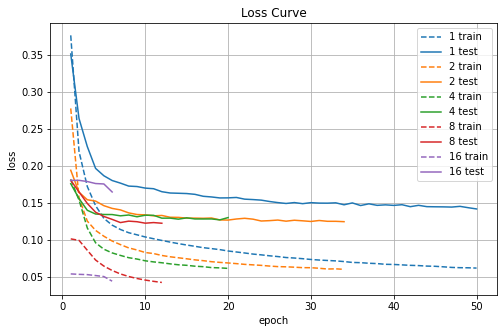

In [ ]:
plt.figure(figsize=(8,5))
for i in range(len(neg_rate_pool)):
    plt.plot(np.arange(1, len(train_losses[i]) + 1), train_losses[i], label=f"{neg_rate_pool[i]:.0f} train", color=plt.cm.tab10(i), linestyle="dashed")
    plt.plot(np.arange(1, len(eval_losses[i]) + 1), eval_losses[i], label=f"{neg_rate_pool[i]:.0f} test", color=plt.cm.tab10(i))
plt.title(f"Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
# plt.savefig("neg_rate.png", bbox_inches="tight")
plt.show()

In [ ]:
print(f"Image Retrieval Median Rank")
for i in range(len(neg_rate_pool)):
    print(f"{neg_rate_pool[i]:.0f} | {image_MedR[i]:.0f}")
print(f"Average Loss from Positive and Negative Pairs")
for i in range(len(neg_rate_pool)):
    print(f"Negative Pairs Rate: {neg_rate_pool[i]:.0f} | total: {eval_losses[i][-1]:.4f}, positive: {eval_loss_decomposed[i][0]:.4f}, negative: {eval_loss_decomposed[i][1]:.4f}")

Image Retrieval Median Rank
1 | 63
2 | 49
4 | 50
8 | 28
16 | 32
Average Loss from Positive and Negative Pairs
Negative Pairs Rate: 1 | total: 0.1416, positive: 0.3163, negative: 0.0979
Negative Pairs Rate: 2 | total: 0.1244, positive: 0.3555, negative: 0.0666
Negative Pairs Rate: 4 | total: 0.1299, positive: 0.4379, negative: 0.0529
Negative Pairs Rate: 8 | total: 0.1222, positive: 0.4900, negative: 0.0303
Negative Pairs Rate: 16 | total: 0.1646, positive: 0.7943, negative: 0.0072


The result suggests the negative pairs rate of 8 is the best among five values. Let's further explore the rates around 8.

In [ ]:
base_epochs = 20
batch_size = 128
embed_dim = 256
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

neg_rate_pool = [6, 8, 10, 12, 14]
train_losses, eval_losses, eval_loss_decomposed, image_MedR = [], [], [], []

for neg_rate in neg_rate_pool:
    print(f"\nNegative Pairs Rate = {neg_rate:.0f}")
    image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
    text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
    criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
    image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
    text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

    trainloader.dataset.set_neg_rate(neg_rate)

    train_loss, eval_loss = [], []
    epochs = math.ceil(base_epochs * (1 + 4) / (1 + neg_rate))
    for epoch in range(epochs):
        trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
        train_loss.append(trainloss)
        evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
        eval_loss.append(evalloss)
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
    pos_loss, neg_loss = utils.eval_decomposed(testloader, image_head, text_head)
    _, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)
    MedR = utils.getMedR(testloader, sim_mat)
    
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    eval_loss_decomposed.append([pos_loss, neg_loss])
    image_MedR.append(MedR["image"])
    neg_rate_loss = {"train": train_losses, "test": eval_losses, "neg_rate": neg_rate_pool, "MedR": image_MedR}
    with open(f"drive/My Drive/finalproj/neg_rate_loss2.pkl", "wb") as f:
        pickle.dump(neg_rate_loss, f)


Negative Pairs Rate = 6
   Epoch: 5 | Training loss: 0.0816 | Test loss: 0.1336
   Epoch: 10 | Training loss: 0.0581 | Test loss: 0.1252
   Epoch: 15 | Training loss: 0.0507 | Test loss: 0.1256

Negative Pairs Rate = 8
   Epoch: 5 | Training loss: 0.0639 | Test loss: 0.1328
   Epoch: 10 | Training loss: 0.0475 | Test loss: 0.1259

Negative Pairs Rate = 10
   Epoch: 5 | Training loss: 0.0560 | Test loss: 0.1430
   Epoch: 10 | Training loss: 0.0419 | Test loss: 0.1277

Negative Pairs Rate = 12
   Epoch: 5 | Training loss: 0.0501 | Test loss: 0.1478

Negative Pairs Rate = 14
   Epoch: 5 | Training loss: 0.0581 | Test loss: 0.1773


In [ ]:
print(f"Image Retrieval Median Rank")
for i in range(len(neg_rate_pool)):
    print(f"{neg_rate_pool[i]:.0f} | {image_MedR[i]:.0f}")
print(f"Average Loss from Positive and Negative Pairs")
for i in range(len(neg_rate_pool)):
    print(f"Negative Pairs Rate: {neg_rate_pool[i]:.0f} | total: {eval_losses[i][-1]:.4f}, positive: {eval_loss_decomposed[i][0]:.4f}, negative: {eval_loss_decomposed[i][1]:.4f}")

Image Retrieval Median Rank
6 | 36
8 | 33
10 | 30
12 | 27
14 | 35
Average Loss from Positive and Negative Pairs
Negative Pairs Rate: 6 | total: 0.1256, positive: 0.4714, negative: 0.0391
Negative Pairs Rate: 8 | total: 0.1264, positive: 0.5030, negative: 0.0323
Negative Pairs Rate: 10 | total: 0.1277, positive: 0.5200, negative: 0.0296
Negative Pairs Rate: 12 | total: 0.1404, positive: 0.6305, negative: 0.0178
Negative Pairs Rate: 14 | total: 0.1747, positive: 0.8631, negative: 0.0026


In [ ]:
neg_rate = 20
print(f"\nNegative Pairs Rate = {neg_rate:.0f}")
image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

trainloader.dataset.set_neg_rate(neg_rate)

train_loss, eval_loss = [], []
epochs = math.ceil(base_epochs * (1 + 4) / (1 + neg_rate))
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 5 == 0:
        print(f"   Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
pos_loss, neg_loss = utils.eval_decomposed(testloader, image_head, text_head)
_, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)
MedR = utils.getMedR(testloader, sim_mat)


Negative Pairs Rate = 20
   Epoch: 5 | Training loss: 0.0429 | Test loss: 0.1800


In [ ]:
print(f"{neg_rate:.0f} | {MedR['image']:.0f}")
print(f"Negative Pairs Rate: {neg_rate:.0f} | total: {eval_loss[-1]:.4f}, positive: {pos_loss:.4f}, negative: {neg_loss:.4f}")

20 | 675
Negative Pairs Rate: 20 | total: 0.1800, positive: 0.9001, negative: 0.0000


## 3. Observation
From the experiments above, 8 - 12 are the best for the negative pairs rate. When the rate is too large, the model starts to focus on avoiding penalities only from negative pairs. With higher negative pairs rate, the average loss from positive pairs increases. However, it doesn't immediately mean that the model's performance is bad as the median rank results show.